# Lab 10 K-means vs. Expectation Maximization in case of clustering task

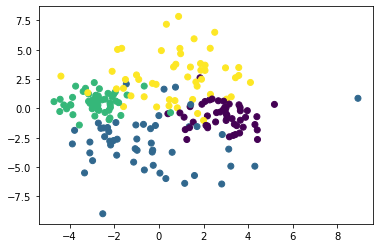

In [188]:
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

random_seed = numpy.random.randint(0,100)
#random_seed = 50
random_seed = 55
#random_seed = 8
#random_seed = 65

component_centers = numpy.array([
    [0,1],
    [0.5,0],
    [0, -1],
    [-0.5,0],
])

circle_cov = numpy.array(
[
    [0.05,0],
    [0,0.05]
]
)

oval_cov = numpy.array(
[
    [0.5,0],
    [0,0.05]
]
)

pi_comps = numpy.array([0.25]*4)

generating_gmm = GaussianMixture(n_components=4)
generating_gmm.fit(numpy.random.rand(10, 2))

generating_gmm.means_ = component_centers
generating_gmm.covariances_ = numpy.array([oval_cov, circle_cov, oval_cov, circle_cov])
generating_gmm.weights_ = pi_comps

def rotate(centroids_list, angle):
    rotation_matrix = numpy.array(
        [
            [numpy.cos(angle), -numpy.sin(angle)],
            [numpy.sin(angle), numpy.cos(angle)],
        ]
    )
    rotated_centroids = []
    for c in centroids_list:
        _c = numpy.array(c) @ rotation_matrix
        rotated_centroids.append(_c.tolist())
        
    return rotated_centroids

X, Y = make_blobs(n_samples=200, centers=rotate(means, 45), n_features=2, cluster_std=[1,2,1,2],
                  random_state=random_seed)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [189]:
gX, c = generating_gmm.sample(500)

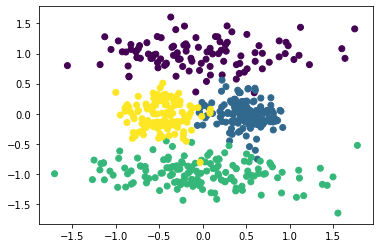

In [190]:
plt.figure()
plt.scatter(gX[:,0], gX[:,1], c = c)
plt.show()

In [191]:
X = gX

# Part 1: K-means recap:

Clustering task can be seen as a specific case of dimensionality reduction with the following constraints:

1. $q = C$ where $C$ is the number of clusters.
2. Resulting reduced vector is a one-hot vector.

Given this we can define the loss function as:

## $$\hat{R} (\mathbf{Z}, \mathbf{W}; \mathbf{X}) = \sum_{k' = 1}^{k} \sum_{j:z_{j,k'} = 1} \| \mathbf{w}_{k'} - \mathbf{x}_j \|_2^2 $$

which effectively means that we aim to minimize the accumulated distance between each data point and its corresponding cluster representative.

Such loss function gives us the closed-form solution for our task:

## $$ \mathbf{w}_{k'} = \frac{1}{|\{ j:z^{(0)}_{j,k'} = 1 \}|} \sum_{j:z^{(0)}_{j,k'} = 1} \mathbf{x}_j.$$

## What does $(0)$ mean here? <-- *discuss*

## $$ \mathbf{Z}^{(0)} = \{ z_1^{(0)}, \dots, z_n^{(0)} \}$$
## $$ \mathbf{z}_i = \text{arg}\min_{k'} \{ \| \mathbf{x}_i - \mathbf{w}_{k'} \|_2^2 \} $$

In [219]:
# computing new z
def expectation(X, C):
    '''
    X: n_samples x dim
    C: n_centers x dim
    '''
    return numpy.sum((X[:, numpy.newaxis, :] - C)**2, axis=-1).argmin(axis=-1)

# computing new cluster representatives
def maximization(X, Z, K):
    '''
    X: n_samples x dim
    C: n_centers x dim
    '''
    C_new = numpy.zeros((K, X.shape[-1]))
    for k in range(K):
        C_new[k, :] = numpy.mean(X[Z == k, :], axis=0)
    return C_new

In [220]:
# doing actual k-means here!
K = 4
C = numpy.random.randn(K, X.shape[-1])


In [221]:
max_iter = 100

eps = 1e-5

for i in range(max_iter):
    Z = expectation(X, C)
    C = maximization(X, Z, K)
    
    if (i > 0) and ((Z_prev - Z) ** 2).sum() < eps and ((C_prev - C) ** 2).sum() < eps:
        print('Done at iteration', i)
        break
    
    Z_prev = numpy.copy(Z)
    C_prev = numpy.copy(C)

Done at iteration 26


In [222]:
def plot_data(X, Z=None, C=None):
    '''
    X: data points, n_samples x dim
    C: cluster centers, n_samples x dim
    Z: cluster assignments, n_samples
    '''

    if Z is None:
        plt.scatter(X[:, 0], X[:, 1], c='m', marker='x', alpha=0.5)
        if C is not None:
            plt.scatter(C[:, 0], C[:, 1], c='b', marker='o')
    else:
        colors = ['r', 'g', 'b', 'c']

        for k in range(C.shape[0]):
            plt.scatter(X[Z == k, 0], X[Z == k, 1], c=colors[k], marker='x', alpha=0.5)
            plt.scatter(C[k, 0], C[k, 1], c=colors[k], marker='s')

    plt.grid(True)
    plt.show()

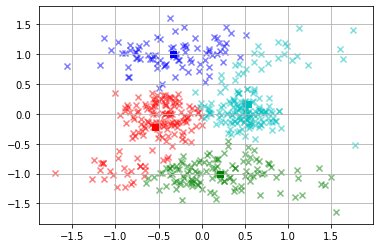

In [223]:
plot_data(X, Z=Z, C=C)

## What does this plot tell us about k-means? <-- *discuss*

# Part 2: Going to Gaussian Mixture Model!

With a probabilistic interpretation we can write the likelihood function of our data point augmented with a latent categorical random variable indicating the cluster its being assigned to. Then we can decompose the joint model using the chain rule:
## $$ p(\mathbf{x}_i, z_i) = p(\mathbf{x}_i|z_i) \cdot p(z_i) = p(z_i) \cdot \mathscr{N}(\mathbf{x}_i; \mathbf{\mu}_{z_i}, \Sigma_{z_i}) $$

Now we can rewrite the probability of a single data point using our joint model and the law of total probability:

## $$ p(\mathbf{x}_i) = \sum_{k \in z_i} p(\mathbf{x}_i, z_i = k) = \sum_{z_i} p(z_i) \cdot \mathscr{N}(\mathbf{x}_i; \mathbf{\mu}_{z_i}, \Sigma_{z_i})$$

Assuming the diagonal covariance of the $\mathscr{N}(\mathbf{x}_i; \mathbf{\mu}_{z_i}, \Sigma_{z_i})$ we can rewrite the joint model as:
## $$ p(\mathbf{x}_i, z_i=k) = p(z_i=k) \prod_{i=1}^{d}\frac{1}{\sqrt{2\pi} \sigma_{k,i}} \exp{\Big(-\frac{(x_i - \mu_{k,i})^2}{2\sigma^2_{k,i}}\Big)}$$ 

## How do we want to optimize our GMM?
Possible choices:
1. Gradient-based optimization (what objective would we use then? This will be a part of your next homework!)
2. Expectation-Maximization algorithm.

While training with EM our aim is to maximize the log-likelihood of our training data: 
## $$F(p, D_{train}) = \sum_{i=1}^{N} \log p(\mathbf{x}_i)$$

Now we can rewrite the $\log p(\mathbf{x}_i)$ for particular data point:
## $$ \log p(\mathbf{x}_i) = \log p(\mathbf{x}_i, z_i) - \log p(z_i | \mathbf{x}_i) =$$
## $$ \log p(\mathbf{x}_i, z_i) -\log Q(z_i) - \log p(z_i | \mathbf{x}_i) + \log Q(z_i)=$$
## $$ \log {\frac{p(\mathbf{x}_i, z_i)}{Q(z_i)}} - \log {\frac{ p(z_i | \mathbf{x}_i)}{Q(z_i)}}= $$
## $$ \sum_{z_i} Q(z_i) \Big[ \log {\frac{p(\mathbf{x}_i, z_i)}{Q(z_i)}} - \log {\frac{ p(z_i | \mathbf{x}_i)}{Q(z_i)}} \Big] =$$
## $$ \sum_{z_i} Q(z_i) \log {\frac{p(\mathbf{x}_i, z_i)}{Q(z_i)}} - \sum_{z_i} Q(z_i) \log {\frac{ p(z_i | \mathbf{x}_i)}{Q(z_i)}} =$$
## $$ \sum_{z_i} Q(z_i) \log p(\mathbf{x}_i, z_i) - \sum_{z_i} Q(z_i) \log Q(z_i) - \sum_{z_i} Q(z_i) \log {\frac{ p(z_i | \mathbf{x}_i)}{Q(z_i)}} =$$\
## $$ \sum_{z_i} Q(z_i) \log p(\mathbf{x}_i, z_i) + H(Q) - KL(Q||p(z_i|\mathbf{x}_i)) $$

Here we introduce additional set of parameters for distribution $Q(z)$: $v_1,\dots, v_q$ where $q$ is the number of clusters. This vector of paramters is introduced for each data point.

Given this reformulation of the single point marginal distribution we see that via maximizing point likelihood we want to minimize the KL divergence betwen $Q(z_i)$ and $p(z_i|\mathbf{x}_i)$ distributions.

Now we iteratively improve $\log p(\mathbf{X})$ by alternating between following steps:
1. Expectation: estimate $v_k$  $\forall k$  for each data point.
2. Maximization: estimate $\mathbf{\mu}_k, \Sigma_k$, $\pi_k$ $\forall k$.

Parameters of $Q$ distributions can be estimated by assuming $Q$ to match posterior distribution $p(z_i|\mathbf{x}_i))$:

## $$ v^{i}_{1\dots q} = \text{Softmax}([ \log{p(z_i=1, \mathbf{x}_i)}, \dots, \log{p(z_i=q, \mathbf{x}_i)} ])$$
## $$ \mu_{k,i} = \sum_{n=1}^N \frac{v_k^n}{\sum_{n'=1}^N v_k^{n'}} x_i^n$$
## $$ p(z=k) = \pi_k = \frac{1}{N} \sum_{n=1}^N v_k^n $$

Parameters of each mixture ($\mathbf{\mu}_k, \Sigma_k, \pi_k$) can be estimated given fixed $v_k$ for each data point (derivation of means and $\pi$ is given in the lecture notes while covariance part is left for you as a homework assignment).

In [231]:
def another_avg(x):
    return x / x.sum(0)

# Expectation step
def em_expectation(X, pi, mu, sigma):
    logp_x_given_z = numpy.log(pi)[:, None] - (X.shape[0]/2)*numpy.log(2*numpy.pi) - ((numpy.log(sigma)/2).sum(1))[:, None] - ((X.T[None,:,:] - mu[:,:,None])**2/(2*sigma[:,:,None])).sum(1)
    return logp_x_given_z

In [232]:
def em_maximization(X, q_mixture_comp):
    sample_weights = another_avg( numpy.exp(q_mixture_comp) )
    sample_weights_summed = sample_weights.sum(1)[:, None]
        
    new_mu = (sample_weights) @ X / sample_weights_summed
    avg_X2 = (sample_weights) @ (X * X) / sample_weights_summed
    
    new_mu_2 = new_mu ** 2
    avg_X_means = new_mu * (sample_weights @ X) / sample_weights_summed
    new_sigma = avg_X2 - 2 * avg_X_means + new_mu_2
    
    new_pi = sample_weights.mean(1)
    
    return new_mu, new_sigma, new_pi  

In [233]:
def get_data_likelihood(X, mu, sigma, pi):
    log_p_X = (numpy.log(pi)[:, None] - (X.shape[0]/2)*numpy.log(2*numpy.pi) - ((numpy.log(sigma)/2).sum(1))[:, None] - ((X.T[None,:,:] - mu[:,:,None])**2/(2*sigma[:,:,None])).sum(1)).sum()   
    return log_p_X

In [234]:
import ipdb
from tqdm import tqdm

# doing actual clustering here!
K = 4

pi = numpy.array([1.0 / K for i in range(K)])
q = numpy.zeros((X.shape[0], K))

#mu = numpy.copy(C) # init from k-means
mu = numpy.random.randn(K, X.shape[-1]) # init randomly

sigma = numpy.empty([K, X.shape[-1]])
sigma.fill(1)

max_iter = 1000
eps = 1e-9
old_likelihood = 0

for i in range(max_iter):
    q = em_expectation(X, pi, mu, sigma)
    _mu, _sigma, _pi = em_maximization(X, q)
    
    mu = _mu
    sigma = _sigma
    pi = _pi
    
    # check the diff between marg likelihood
    likelihood = get_data_likelihood(X, mu, sigma, pi)

    if numpy.abs((likelihood - old_likelihood)) < eps:
        print('Done at iteration', i)
        break
    else:
        old_likelihood = likelihood

Done at iteration 160


In [235]:
def get_clusters(X, mu, sigma, pi_mixture_comp):
    clusters = []
    logps = numpy.log(pi)[:, None] - (X.shape[0]/2)*numpy.log(2*numpy.pi) - ((numpy.log(sigma)/2).sum(1))[:, None] - ((X.T[None,:,:] - mu[:,:,None])**2/(2*sigma[:,:,None])).sum(1)
    clusters = numpy.argmax(logps, axis=0)

    return clusters

#def get_clusters(X, mu, sigma, pi):
emc = numpy.array(get_clusters(X, mu, sigma, pi))

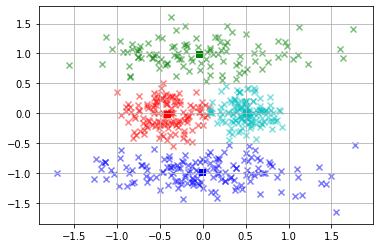

In [236]:
plot_data(X, Z=emc, C=mu) # EM

In [216]:
mu

array([[-0.00859847, -0.98505807],
       [-0.4232508 , -0.01881946],
       [ 0.49952663,  0.0102435 ],
       [-0.04151703,  0.99140681]])

In [217]:
sigma

array([[0.42376191, 0.04186751],
       [0.0660439 , 0.05101959],
       [0.03726707, 0.03807021],
       [0.4297532 , 0.04905816]])

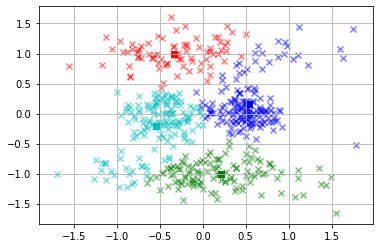

In [218]:
plot_data(X, Z=Z, C=C) # kmeans

# Plugging in Scikit learn GMM

In [72]:
from sklearn.mixture import GaussianMixture

In [224]:
gmm = GaussianMixture(n_components=4, covariance_type='diag', init_params='random', max_iter=1000, tol=10e-10)

In [225]:
gmm.fit(X)

GaussianMixture(covariance_type='diag', init_params='random', max_iter=1000,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=1e-09, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [226]:
gmm.predict(X)

array([3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [227]:
gmm.means_

array([[-0.42327643, -0.01882209],
       [-0.00859778, -0.98505801],
       [ 0.49950622,  0.01024512],
       [-0.04151692,  0.99140724]])

In [228]:
gmm.covariances_

array([[0.06603429, 0.0510223 ],
       [0.42376288, 0.0418686 ],
       [0.03727518, 0.03807061],
       [0.42975457, 0.04905908]])

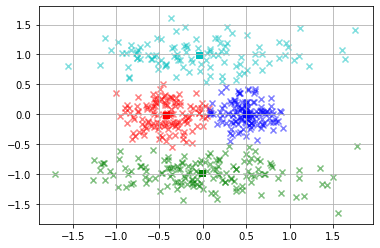

In [229]:
plot_data(X, Z=gmm.predict(X), C=gmm.means_) # sklearn GMM

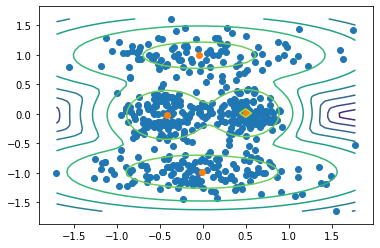

In [230]:
X_plot, Y_plot = numpy.meshgrid(numpy.linspace(X[:,0].min(), X[:,0].max()), numpy.linspace(X[:,1].min(), X[:,1].max()))
XX = numpy.array([X_plot.ravel(), Y_plot.ravel()]).T
Z = gmm.score_samples(XX)
Z = Z.reshape((50,50))
 
plt.contour(X_plot, Y_plot, Z)
plt.scatter(X[:, 0], X[:, 1])

plt.scatter(gmm.means_[:,0], gmm.means_[:,1])

plt.show()